# **연세-네이버클라우드 데이터사이언스 교육과정**
## 단어 표상(Word Representation)

박기영 (연세대 경제학부)

03NLP_WordRepresentation.ipynb의 목차

1. 예: 원-핫 인코딩
2. 빈도에 기반한 단어 표상
3. 확률적 단어 표상
4. 실습: Kaggle 와인 리뷰
5. 실습: 네이버 영화평 
6. Digression: 유사도 계산



In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas_datareader as pdr
from datetime import date

import seaborn as sns

%config InlineBackend.figure_format = 'retina'   # for retina display in Mac
np.set_printoptions(precision=3, suppress=True)  # for pretty display of numpy arrays
pd.options.display.float_format = '{:,.3f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 10

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)
plt.rc('legend', fontsize=16) 

# for Korean fonts 
plt.rcParams['axes.unicode_minus'] = False

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(14,8)})

In [46]:
# 각 셀마다 execution time을 측정
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.76 s (started: 2021-02-10 03:31:34 +00:00)


# 단어 표상(Word Representation)

전처리된 단어의 집합(corpus)을 컴퓨터가 이해할 수 있게 수학적으로, 또는 벡터 공간에 표현하는 과정이며 단어 벡터(word vector) 또는 단어 임베딩(word embedding)은 단어 표상의 하위 개념임. 

### 예: 원-핫 인코딩(One-Hot Encoding)

- 단어집합(word vocabulary): 텍스트의 모든 단어를 중복되지 않게 모아 놓은 단어 집합
- 정수 인코딩: 단어집합의 단어들에 정수를 부여하는 작업
- 원-핫 인코딩: 관심 단어에 인덱스 1을 부여하고 다른 단어들에는 0을 부여하는 작업
- 예: 출처(https://medium.com/intelligentmachines/word-embedding-and-one-hot-encoding-ad17b4bbe111)


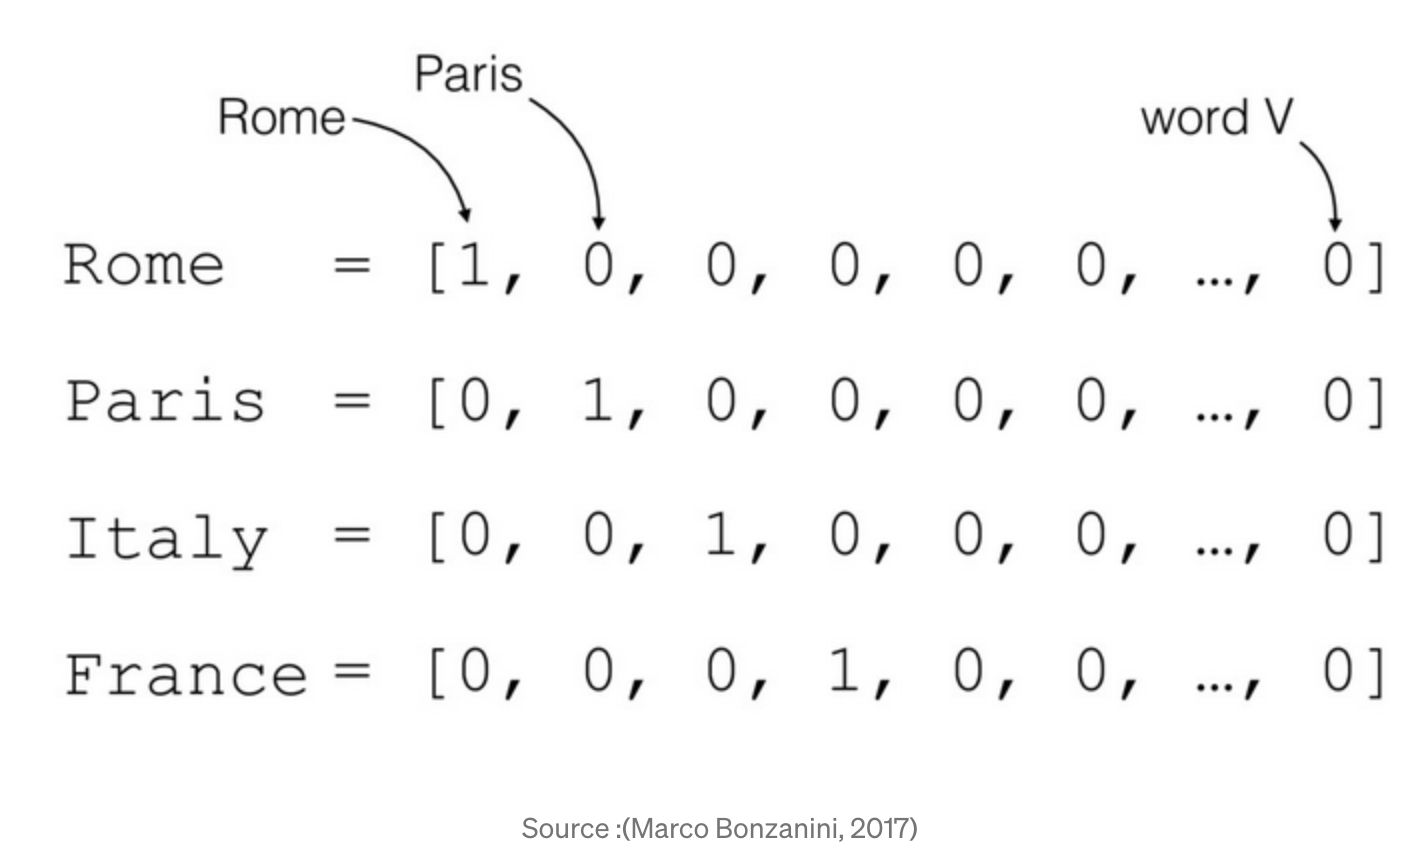

### keras를 이용한 정수 인코딩, 원-핫 인코딩의 예

- 아래는 keras의 to_categorical()을 이용해서 정수 인코딩과 원-핫 인코딩을 하는 예를 보여 줌.

In [4]:
# keras의 to_categorical 불러오기
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

time: 1.8 s (started: 2021-02-10 02:44:49 +00:00)


In [5]:
# 단어 집합의 생성과 정수 인코딩
# 각 단어들에 정수가 부여 됨
text = "what we talk about when we talk about love"

t = Tokenizer()
t.fit_on_texts([text])
print(t.word_index)

{'we': 1, 'talk': 2, 'about': 3, 'what': 4, 'when': 5, 'love': 6}
time: 1.9 ms (started: 2021-02-10 02:44:56 +00:00)


In [6]:
# 위의 단어 집합 원소들(we, talk, about, love, what, when)로만 구성된 문장이 있을 경우
# texts_to_sequences()를 이용해서 문장을 정수 시퀀스로 바꿀 수 있음
sub_text="we talk about love"
encoded=t.texts_to_sequences([sub_text])
print(encoded)

[[1, 2, 3, 6]]
time: 3.05 ms (started: 2021-02-10 02:45:17 +00:00)


In [7]:
# 위의 정수 인코딩된 문장을 원-핫 인코딩으로 변환
# 각각, 1, 2, 3, 5, 4에 해당되는 경우에 1의 값을 가지고 나머지는 모두 0임. 
one_hot = to_categorical(encoded)
print(one_hot)

[[[0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]]
time: 9.78 ms (started: 2021-02-10 02:45:28 +00:00)


### 원-핫 인코딩의 단점

- 단어의 수가 증가할수록 단어 집합의 크기가 커지고 이에 비례해서 벡터의 크기가 커짐
  - 차원의 저주(curse of dimentionality). 
  - 매우 비효율적인 연산을 하게 되고 벡터들을 모아놓은 희소 행렬(sparse matrix)의 문제 발생  
- 단어의 유사도를 잡아내지 못 함.
  - 한국, 서울, 일본, 동경 네 단어에 대해서 [1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]의 원-핫 인코딩을 했을 때 네 단어 사이의 관계를 잡아내기 어려움.
  - 유사도를 알 수 없기 때문에 검색시 연관 검색어를 함께 찾지 못 하는 문제가 있을 수 있음.

$\rightarrow$ 위와 같은 단점을 보완하기 위해 단어의 잠재 의미를 반영해서 다차원 공간에 벡터화 하는 기법을 사용함. 


아래에서는 다음 순서로 살펴 봄.

- 빈도에 기반한 단어 표상(Count-Based Word Representation)
  - BOW (Bag of Words)
  - 문서단어행렬(DTM: Document Term Matrix)
  - TF-IDF (Term Frequency-Inverse Document Frequency)
  - 동반출현행렬(Co-Occurrence Matrix)
- 확률적 단어 표상(Distributional Word Representation) 
  - skip-gram
  - CBOW (Continuous Bag-of-Words)

단어 표상 기법들을 다르게 분류할 수도 있음: 그림 출처(https://wikidocs.net/31767)



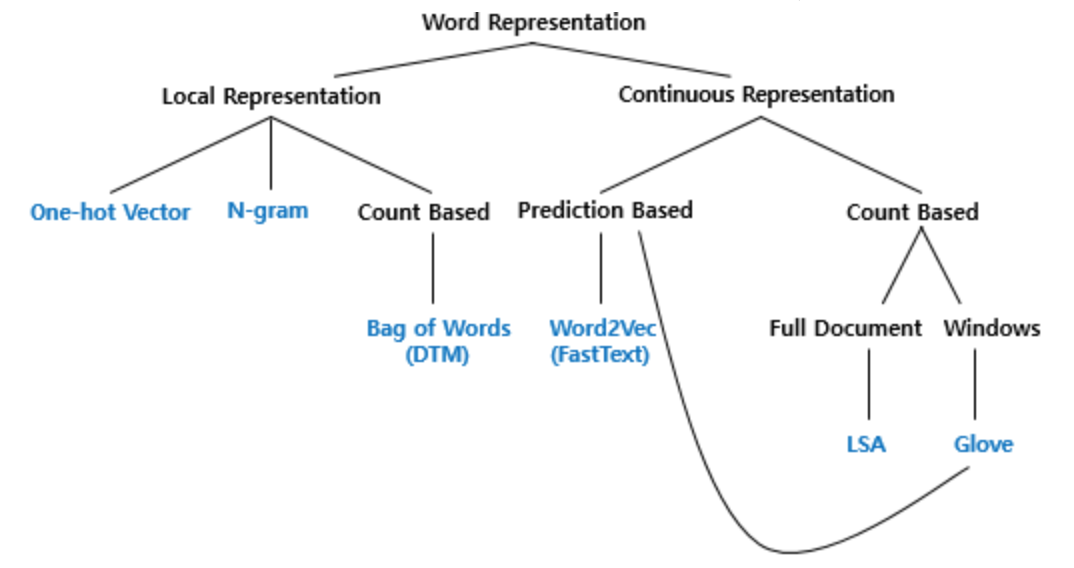

## 빈도에 기반한 단어 표상(Count-Based Word Representation)

### BOW (Bag of Words)

- BOW: 단어들의 순서는 고려하지 않고 단어들의 출현 빈도(frequency)에만 집중해서 텍스트 데이터를 수치화하는 방법
- 말그대로 단어들(words)을 가방(bag)에 넣고 (순서는 중요하지 않게) 흔든 다음 몇 개의 단어들이 가방 안에 있나를 세는 것과 유사한 개념임. 
- BOW를 만드는 과정:
  (1) 각 단어에 고유한 정수 인덱스를 부여
  (2) 각 인덱스 위치에 토근의 등장 회수를 기록한 벡터 작성


In [8]:
# sklearn의 CountVectorizer로 BOW 만들기
from sklearn.feature_extraction.text import CountVectorizer
corpus = ['what we talk about when we talk about love']
vector = CountVectorizer()

# corpus의 각 단어 빈도
print(vector.fit_transform(corpus).toarray()) 
# 각 단어의 인덱스
print(vector.vocabulary_) # 각 단어의 인덱스가 어떻게 부여되었는지를 보여준다.

[[2 1 2 2 1 1]]
{'what': 4, 'we': 3, 'talk': 2, 'about': 0, 'when': 5, 'love': 1}
time: 208 ms (started: 2021-02-10 02:47:47 +00:00)


- 0 인덱스 자리에 있는 'about'이 2회 출현하였음을 알 수 있음.
- 2 인덱스 자리(세번째 자리)에 있는 'talk'도 2회 출현 

In [ ]:
# 불용어를 제거한 BOW
vect = CountVectorizer(stop_words="english")
print(vect.fit_transform(corpus).toarray())
print(vect.vocabulary_)

[[1 2]]
{'talk': 1, 'love': 0}
time: 4.83 ms (started: 2021-01-31 06:58:33 +00:00)


### 문서단어행렬(DTM: Document Term Matrix)

- 문서 단어 행렬(Document-Term Matrix, DTM)이란 다수의 문서에서 등장하는 각 단어들의 빈도를 행렬로 표현함.
- 달리 표현하면 각 문서에 대한 BOW를 하나의 행렬로 만든 것임. 

In [9]:
corpus = [
          'when we talk about love',
          'what we talk about love',
          'drinking gins and talking about love'
]

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

['about', 'and', 'drinking', 'gins', 'love', 'talk', 'talking', 'we', 'what', 'when']
time: 10.8 ms (started: 2021-02-10 02:50:14 +00:00)


In [10]:
print(X.toarray())

[[1 0 0 0 1 1 0 1 0 1]
 [1 0 0 0 1 1 0 1 1 0]
 [1 1 1 1 1 0 1 0 0 0]]
time: 1.35 ms (started: 2021-02-10 02:50:17 +00:00)


- 위 결과를 보기 좋게 정리하면 다음과 같이 되며 아래 형태의 행렬을 DTM라 함.

||about|and|drinking|gins|love|talk|talking|we|what|when|
|-|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|문장1|1|0|0|0|1|1|0|1|0|1|
|문장2|1|0|0|0|1|1|0|1|1|0|
|문장3|1|1|1|1|1|0|1|0|0|0|




**DTM의 단점**
- 위의 예에서는 DTM이 3*9 행렬이었지만 일반적인 문서라면 행렬의 크기가 매우 크면서 동시에 0이 굉장히 많이 들어가 있는 희소 행렬(sparse matrix)이 되는데 이 경우 많은 양의 저장공간이 필요하며 높은 연산능력이 요구됨. 
- 빈도 측면의 정보만 줌: 예를 들어, 어느 문서나 the가 많이 들어가 있을 수 있는데 the가 많이 들어간 문서들끼리 유사도가 높다고 판단할 수 없음 $\rightarrow$ TF-IDF

### TF-IDF (Term Frequency-Inverse Document Frequency)

- Salton and McGill (1983)
- 참고자료: https://cs.pomona.edu/~dkauchak/classes/f09/cs160-f09/lectures/lecture5-tfidf.pdf
- 어떤 문서가 특정 주제를 다룰 경우 해당 주제와 관련된 단어 또는 단어의 조합이 자주 등장함 $\rightarrow$ TF (Term Frequency)
- 빈도가 높은 단어라도 모든 문서에 흔히 등장하는 경우 낮은 가중치를 부여 $\rightarrow$ IDF (Inverse Term Frequency)
- 예: 경제와 관련된 문헌의 경우 '경제'란 용어가 공통적으로 많이 등장하므로 출현 빈도에 비해 중요도를 낮게 책정
- TF-IDF 계산의 예 (TF-IDF를 계산하는 방법은 다양함):
\begin{equation}
\frac{f}{T}\log(\frac{N}{n})
\end{equation}
  - T = 문서의 총 단어수
  - f = 특정 단어가 어떤 문서 D에서 출현한 회수
  - N = 문서의 총 개수
  - n = N건의 문서 중 특정 단어가 출현한 회수


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfv = TfidfVectorizer().fit(corpus)
print(tfidfv.transform(corpus).toarray())

[[0.35  0.    0.    0.    0.35  0.45  0.    0.45  0.    0.592]
 [0.35  0.    0.    0.    0.35  0.45  0.    0.45  0.592 0.   ]
 [0.272 0.461 0.461 0.461 0.272 0.    0.461 0.    0.    0.   ]]
time: 23.7 ms (started: 2021-02-10 02:52:08 +00:00)


In [12]:
print(tfidfv.vocabulary_)

{'when': 9, 'we': 7, 'talk': 5, 'about': 0, 'love': 4, 'what': 8, 'drinking': 2, 'gins': 3, 'and': 1, 'talking': 6}
time: 3.95 ms (started: 2021-02-10 02:52:11 +00:00)


## 확률적 단어 표상(Distributional Word Representation) 

- 확률적 단어 표상: "유사한 의미를 가진 단어는 유사한 분포를 가진다"는 언어학의 확률적 분포 가설(distributional hypothesis)에 기반해서 단어를 수치화시킴
- "출출한데 __이나 먹을까?"의 빈 칸에 '라면', '빵' 모두 들어갈 수 있는데 언어의 확률적 분포 가설에 따르면 두 단어는 유사한 단어로 분류됨.

**희소표현(sparse representation)**
- 앞에서 살펴 본 BOW는 0과 1의 값을 가지는 원-핫 인코딩(one-hot encoding)은 희소표현(그 중에서도 희소벡터)의 예임. 
- 희소벡터의 단점은 단어 수에 비례해서 벡터의 차원이 커짐. 예를 들어, 해당 코퍼스에 단어가 10,000개 있다면 벡터의 차원도 10,000이어야 함. 
- 이 때 해당 코퍼스에서 1회 출현한 '커피'라는 단어를 표현하려면 아래와 같이 10,000*1 벡터를 사용해야 함:
\begin{equation}
[0,0,...,1,...,0]_{10,000\times1}
\end{equation}

**밀집표현(dense representation)**
- 희소벡터를 개발자가 정의한 크기로 '밀집'해서 표현할 수 있음
- 예를 들어, 벡터의 크기를 256으로 한정하고 대신 0과 1이 아니라 실수(real numbers)로 표시되는 벡터 $\rightarrow$ 밀집벡터
\begin{equation}
[0.31,-1.1,...,0.4,..,0.24]_{256\times1}
\end{equation}

**워드 임베딩(word embedding)**
- 단어를 밀집 벡터(dense vector)의 형태로 표현하는 방법
- 대표적 방법론: Mikolov et al. (2013)의 word2vec, FastText, GloVe

### word2vec

- Mikolov et al. (2013): 연산량을 획기적으로 줄이는 한편 정확도도 높일 수 있는 확률적 단어 표상 기법인 word2vec 개발
- word2vec에서 신경망을 훈련시키는 방법으로는 CBOW (Continuous Bag of Words)와 skip-gram 두 가지 모델이 있음.
- CBOW는 어떤 단어를 주변 단어들을 통해 예측하는 반면, skip-gram은 어떤 단어를 가지고 주변 단어들을 예측하는 방법임. 
  - CBOW 예시: "철수는 출출해서 __을 끓여 먹었다"에서 빈 칸의 단어를 예측하는 모형
  - skip-gram: "_____ ______  라면을  __ ___"에서 주변 단어들을 예측하는 모형

- According to Mikolov
  - CBOW: skipgram보다 훈련시키는 속도가 몇 배 빠르고, 자주 출현하는 단어들에 대해서 정확도가 조금 더 높음. 
  - Skip-gram: 훈련 데이터가 작아도 상대적으로 잘 작동하며 자주 나오지 않는 단어나 어구도 잘 잡아냄. 


- word2vec의 장점:
  - one-hot encoder에 비해 저차원에서 분석이 가능
  - 단어들간 '거리'가 유의미한 정보를 제공: 예를 들어 엄마, 아빠, 여자, 남자를 word2vec을 이용해서 단어 벡터를 만들었을 때 '엄마'와 '아빠' 벡터 사이 거리와 '여자'와 '남자' 벡터 사이 거리가 같거나 비슷하게 나옴.

그림 출처: https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8

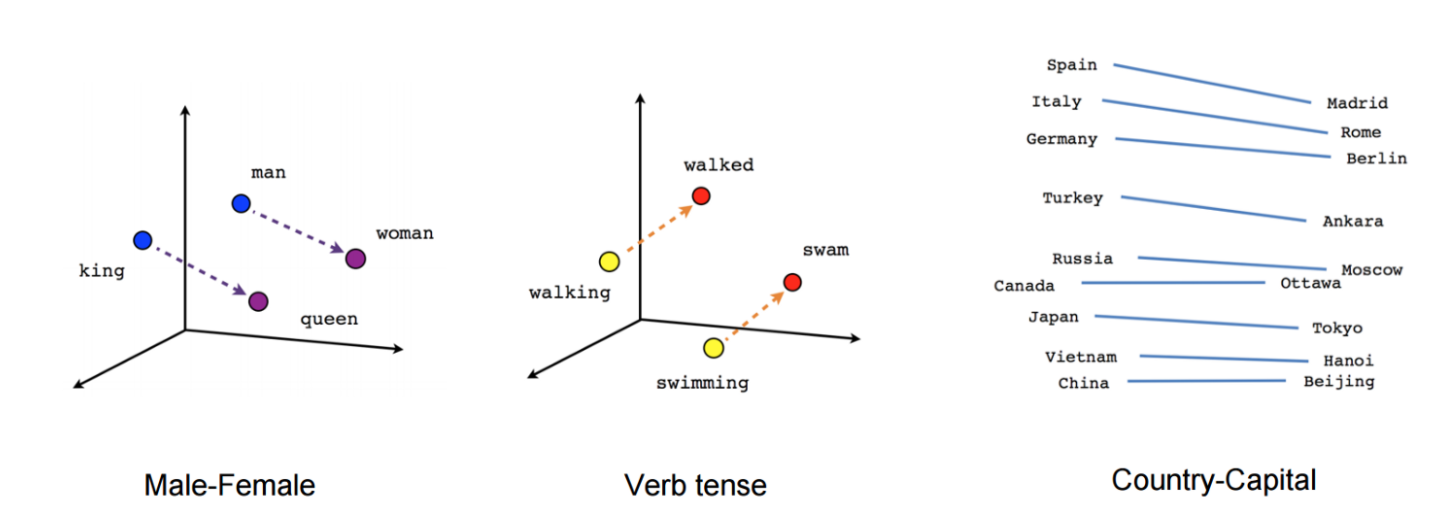

**Embedding Projector**

- https://projector.tensorflow.org/
- 'happy' 단어를 입력하고 결과를 확인해 보시오. 

**한국어 벡터 연산 사이트**
- http://w.elnn.kr/search/

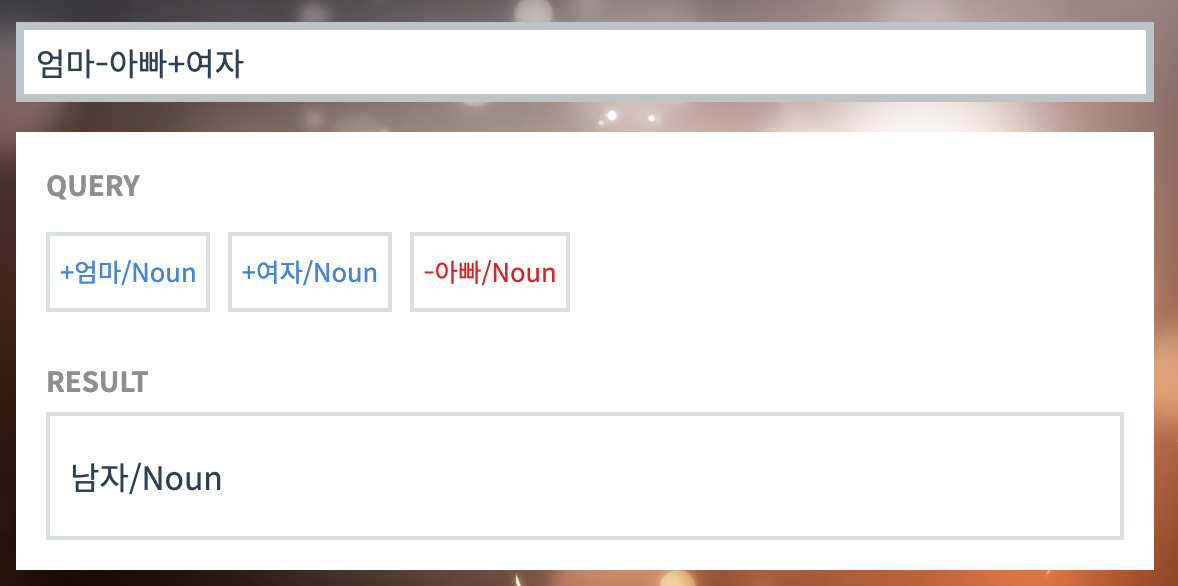

## 실습: Kaggle 와인 리뷰

### 유사도 계산
- Kaggle 와인 리뷰 단어들에 Gensim의 Word2Vec 적용

In [13]:
# mount Google drive before executing this cell 

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/.kaggle/"

time: 1.78 ms (started: 2021-02-10 02:58:20 +00:00)


In [14]:
# List available datasets.
!kaggle datasets list

ref                                                       title                                                size  lastUpdated          downloadCount  
--------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                           6MB  2021-02-09 19:57:32            547  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020                    16KB  2021-01-30 14:20:45            483  
aagghh/crypto-telegram-groups                             Crypto telegram groups                              297MB  2021-02-02 09:58:25             92  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                               1MB  2021-01-29 13:53:50            108  
timoboz/superbowl-history-1967-2020                       Superbowl History 

In [15]:
!kaggle --version

Kaggle API 1.5.4
time: 431 ms (started: 2021-02-10 02:58:27 +00:00)


In [16]:
# kaggle 명령어 update가 필요하다고 하면 아래 명령어 실행
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=ca596f832eb567a7f518bc1c72c0cc890c0a94aa32d68826fea7a12256bb1da6
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
time: 2.65 s (started: 2021-02-10 02:58:28 +00:00)


In [17]:
# 캐글에서 와인 리뷰 데이터 불러오기 
# 구글 드라이브를 마운트하고 아래 구글 드라이브 내 링크를 본인의 것으로 수정할 필요가 있음
!kaggle datasets download -d zynicide/wine-reviews  \
    -p "/content/drive/MyDrive/Colab Notebooks/Teaching/2021YonseiNaverCloud_NLP/data/" 

wine-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
time: 2.33 s (started: 2021-02-10 02:59:05 +00:00)


In [19]:
%cd "/content/drive/MyDrive/Colab Notebooks/Teaching/2021YonseiNaverCloud_NLP/data/"
!pwd

/content/drive/MyDrive/Colab Notebooks/Teaching/2021YonseiNaverCloud_NLP/data
/content/drive/MyDrive/Colab Notebooks/Teaching/2021YonseiNaverCloud_NLP/data
time: 132 ms (started: 2021-02-10 02:59:24 +00:00)


In [20]:
# check what's in zip file
!unzip -l "wine-reviews.zip"

Archive:  wine-reviews.zip
  Length      Date    Time    Name
---------  ---------- -----   ----
 52908706  2019-09-20 18:04   winemag-data-130k-v2.csv
 79279294  2019-09-20 18:04   winemag-data-130k-v2.json
 49784334  2019-09-20 18:04   winemag-data_first150k.csv
---------                     -------
181972334                     3 files
time: 3.55 s (started: 2021-02-10 02:59:26 +00:00)


In [21]:
# 압축 풀기 
!unzip "wine-reviews.zip"

Archive:  wine-reviews.zip
replace winemag-data-130k-v2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: winemag-data-130k-v2.csv  
  inflating: winemag-data-130k-v2.json  
  inflating: winemag-data_first150k.csv  
time: 20.3 s (started: 2021-02-10 02:59:31 +00:00)


In [22]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.head(3)

,Unnamed: 0,country,description,designation,points,...,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,...,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,...,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,...,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


time: 1.08 s (started: 2021-02-10 02:59:55 +00:00)


In [23]:
# description에서 구두점 제거
df['description'].replace({ r"[^a-zA-Z0-9]+" :' '}, inplace= True, regex = True)

# 소문자로 변환
df.description = df.description.str.lower()

time: 2.2 s (started: 2021-02-10 03:01:14 +00:00)


In [25]:
df.head(3)

,Unnamed: 0,country,description,designation,points,...,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,aromas include tropical fruit broom brimstone ...,Vulkà Bianco,87,...,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,this is ripe and fruity a wine that is smooth ...,Avidagos,87,...,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,tart and snappy the flavors of lime flesh and ...,NaN,87,...,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


time: 25.7 ms (started: 2021-02-10 03:01:22 +00:00)


In [26]:
# description 부분을 tokenize
import nltk
nltk.download('punkt')

df['description'] = df.apply(lambda row: nltk.word_tokenize(row['description']), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
time: 39.3 s (started: 2021-02-10 03:01:33 +00:00)


In [27]:
df.head(1)

,Unnamed: 0,country,description,designation,points,...,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"[aromas, include, tropical, fruit, broom, brim...",Vulkà Bianco,87,...,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


time: 23.2 ms (started: 2021-02-10 03:02:39 +00:00)


In [28]:
df['description'].replace({ r"[^a-zA-Z0-9]+" :' '}, inplace= True, regex = True)

time: 84.7 ms (started: 2021-02-10 03:02:54 +00:00)


In [29]:
df.head(1)

,Unnamed: 0,country,description,designation,points,...,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"[aromas, include, tropical, fruit, broom, brim...",Vulkà Bianco,87,...,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


time: 23 ms (started: 2021-02-10 03:02:58 +00:00)


In [30]:
df1 = df[['country','description','designation','title','variety','winery']]
df1.head(1)

,country,description,designation,title,variety,winery
0,Italy,"[aromas, include, tropical, fruit, broom, brim...",Vulkà Bianco,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


time: 33.1 ms (started: 2021-02-10 03:03:13 +00:00)


In [31]:
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
df2.head()

0    Italy,['aromas', 'include', 'tropical', 'fruit...
1    Portugal,['this', 'is', 'ripe', 'and', 'fruity...
2    US,['tart', 'and', 'snappy', 'the', 'flavors',...
3    US,['pineapple', 'rind', 'lemon', 'pith', 'and...
4    US,['much', 'like', 'the', 'regular', 'bottlin...
dtype: object

time: 10.9 s (started: 2021-02-10 03:03:20 +00:00)


In [32]:
df2.replace({ r"[^a-zA-Z0-9]+" :' '}, inplace= True, regex = True)
df2.head(3)

0    Italy aromas include tropical fruit broom brim...
1    Portugal this is ripe and fruity a wine that i...
2    US tart and snappy the flavors of lime flesh a...
dtype: object

time: 2.83 s (started: 2021-02-10 03:03:41 +00:00)


**중요**

gensim의 word2vec은 input 형태가 list 이어야 하며, 각 문서도 list로 구별되고, list의 구성요소는 각 문서에서 나온 token들로 이루어짐

In [33]:
df_clean = pd.DataFrame({'clean': df2})

time: 4.62 ms (started: 2021-02-10 03:03:55 +00:00)


In [34]:
 sent = [row.split(' ') for row in df_clean['clean']]

time: 1.28 s (started: 2021-02-10 03:04:13 +00:00)


In [35]:
sent[:2]

[['Italy',
  'aromas',
  'include',
  'tropical',
  'fruit',
  'broom',
  'brimstone',
  'and',
  'dried',
  'herb',
  'the',
  'palate',
  'isn',
  't',
  'overly',
  'expressive',
  'offering',
  'unripened',
  'apple',
  'citrus',
  'and',
  'dried',
  'sage',
  'alongside',
  'brisk',
  'acidity',
  'Vulk',
  'Bianco',
  'Nicosia',
  '2013',
  'Vulk',
  'Bianco',
  'Etna',
  'White',
  'Blend',
  'Nicosia'],
 ['Portugal',
  'this',
  'is',
  'ripe',
  'and',
  'fruity',
  'a',
  'wine',
  'that',
  'is',
  'smooth',
  'while',
  'still',
  'structured',
  'firm',
  'tannins',
  'are',
  'filled',
  'out',
  'with',
  'juicy',
  'red',
  'berry',
  'fruits',
  'and',
  'freshened',
  'with',
  'acidity',
  'it',
  's',
  'already',
  'drinkable',
  'although',
  'it',
  'will',
  'certainly',
  'be',
  'better',
  'from',
  '2016',
  'Avidagos',
  'Quinta',
  'dos',
  'Avidagos',
  '2011',
  'Avidagos',
  'Red',
  'Douro',
  'Portuguese',
  'Red',
  'Quinta',
  'dos',
  'Avidagos']]

time: 8.1 ms (started: 2021-02-10 03:04:16 +00:00)


In [36]:
from gensim.models import Word2Vec

time: 408 ms (started: 2021-02-10 03:04:23 +00:00)


**Word2Vec의 하이퍼파라미터 값**
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원 (default = 100)
- window = 컨텍스트 윈도우 크기 (default = 5)
- min_count = 단어 최소 빈도 수 제한 (default = 5. 빈도가 적은 단어들은 학습하지 않음)
- workers = 학습을 위한 프로세스 수 (default = 3)
- sg = 0은 CBOW, 1은 Skip-gram.



In [ ]:
model = Word2Vec(sent, min_count=1,size=50, workers=3, window =3, sg = 1)

time: 2min 38s (started: 2021-01-31 07:32:23 +00:00)


In [ ]:
# embedding vector
print(model['Douro'])
print(model['Douro'].shape)

[-1.839 -0.114  0.539 -1.406  0.291  0.859 -0.143 -1.149  0.412  0.167
  0.62  -0.286 -0.416 -0.074 -0.286  0.676  0.998 -0.809  0.514 -0.243
 -1.22  -0.833 -0.856 -1.82   0.557  0.589  0.4    1.286 -2.135  0.272
  0.648  0.785 -0.319 -0.361 -0.801 -1.527 -0.575  0.487  1.081 -0.087
  0.885  0.58   0.064  0.089  2.105  0.367  0.718  0.193 -0.448 -0.389]
(50,)
time: 4.93 ms (started: 2021-01-31 07:38:24 +00:00)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Douro와 Napa의 유사도
model.similarity('Douro','Napa')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


0.40409967

time: 5.2 ms (started: 2021-01-31 07:38:50 +00:00)


In [ ]:
# Douro와 Rioja의 유사도
model.similarity('Douro','Rioja')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


0.53863883

time: 9.03 ms (started: 2021-01-31 07:41:02 +00:00)


In [ ]:
model.wv.most_similar('Douro')

[('Portuguese', 0.894761860370636),
 ('LDA', 0.8721486926078796),
 ('Velhas', 0.8709185123443604),
 ('Beira', 0.8665103912353516),
 ('Prats', 0.8664751648902893),
 ('Bairrada', 0.8645000457763672),
 ('Symington', 0.8631594181060791),
 ('vora', 0.8558931946754456),
 ('Marit', 0.8467918038368225),
 ('Interior', 0.8465670347213745)]

time: 36.8 ms (started: 2021-01-31 07:41:07 +00:00)


In [ ]:
model.wv.most_similar('ripe')

[('rich', 0.9172917604446411),
 ('generous', 0.9154788851737976),
 ('juicy', 0.9014463424682617),
 ('oodles', 0.8832120299339294),
 ('fleshy', 0.8812078237533569),
 ('concentrated', 0.8757873177528381),
 ('ultrarich', 0.8659576773643494),
 ('extravagantly', 0.865654706954956),
 ('gushing', 0.8649813532829285),
 ('brim', 0.8647423982620239)]

time: 8.9 ms (started: 2021-01-31 07:41:20 +00:00)


In [ ]:
model.wv.most_similar('earthy')

[('woodsy', 0.9448891878128052),
 ('mossy', 0.9105333685874939),
 ('barnyardy', 0.9064480066299438),
 ('foresty', 0.9011293053627014),
 ('leathery', 0.8995677828788757),
 ('feral', 0.8989258408546448),
 ('meaty', 0.885193407535553),
 ('herbal', 0.8841747045516968),
 ('brambly', 0.8836011290550232),
 ('sauvage', 0.8821799755096436)]

time: 10.8 ms (started: 2021-01-31 07:41:27 +00:00)


### T-SNE 시각화

In [ ]:
# source: https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92

def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.similar_by_word(word)

    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

time: 15.2 ms (started: 2021-01-31 07:42:50 +00:00)


In [ ]:
from sklearn.manifold import TSNE

time: 164 ms (started: 2021-01-31 07:42:53 +00:00)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


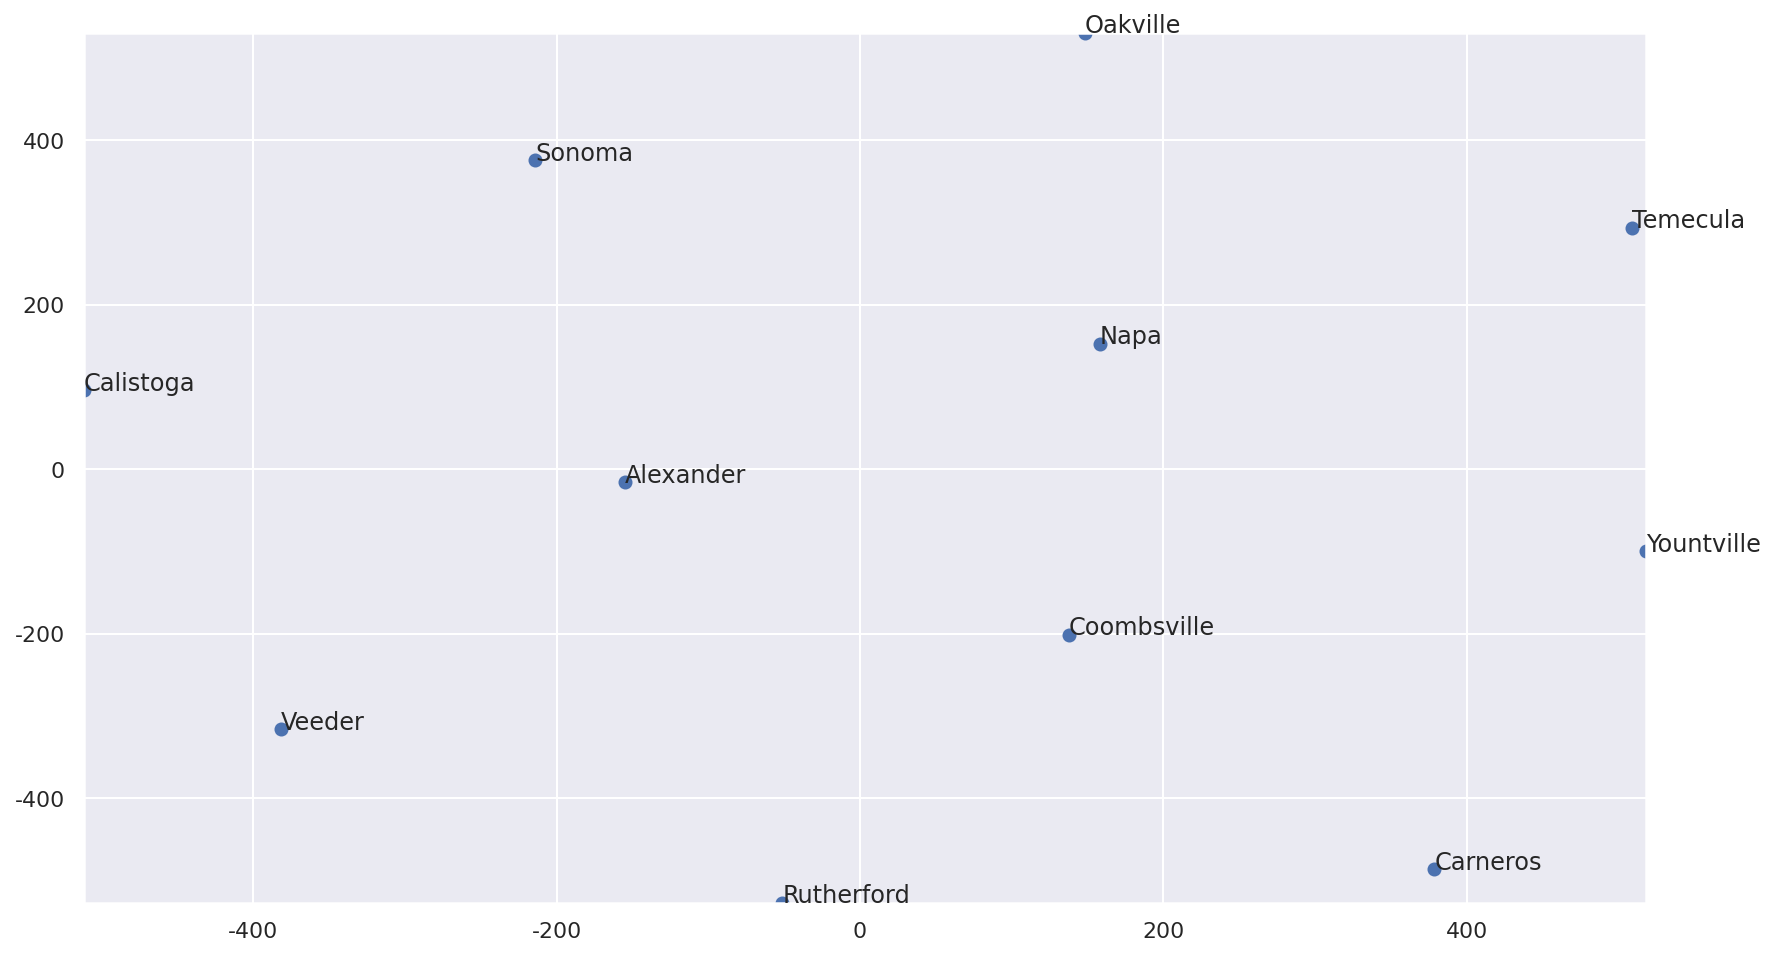

time: 861 ms (started: 2021-01-31 07:42:55 +00:00)


In [ ]:
display_closestwords_tsnescatterplot(model, 'Napa', 50)

## 실습: 네이버 영화평

### Word2Vec으로 유사어 구하기

In [37]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 29.7MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 
     |████████████████████████████████| 460kB 40.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
time: 6.01 s (started: 2021-02-10 03:08:58 +00:00)


In [38]:
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

time: 465 ms (started: 2021-02-10 03:09:06 +00:00)


In [39]:
# 네이버 영화평 불러오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f0d0bbe2978>)

time: 3.1 s (started: 2021-02-10 03:09:09 +00:00)


In [40]:
train_data = pd.read_table('ratings.txt')
train_data.info()
train_data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


time: 502 ms (started: 2021-02-10 03:09:14 +00:00)


In [41]:
# missing value 확인
train_data.isnull().values.any()

True

time: 26.9 ms (started: 2021-02-10 03:09:20 +00:00)


In [42]:
train_data = train_data.dropna(how ='any')
len(train_data)

199992

time: 70.4 ms (started: 2021-02-10 03:09:26 +00:00)


In [43]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head(5)

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


time: 473 ms (started: 2021-02-10 03:10:01 +00:00)


In [45]:
# 불용어 정의
stopwords = ['영화','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

time: 1.22 ms (started: 2021-02-10 03:10:18 +00:00)


In [ ]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요, 약 25분)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

time: 25min 26s (started: 2021-01-31 08:19:33 +00:00)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


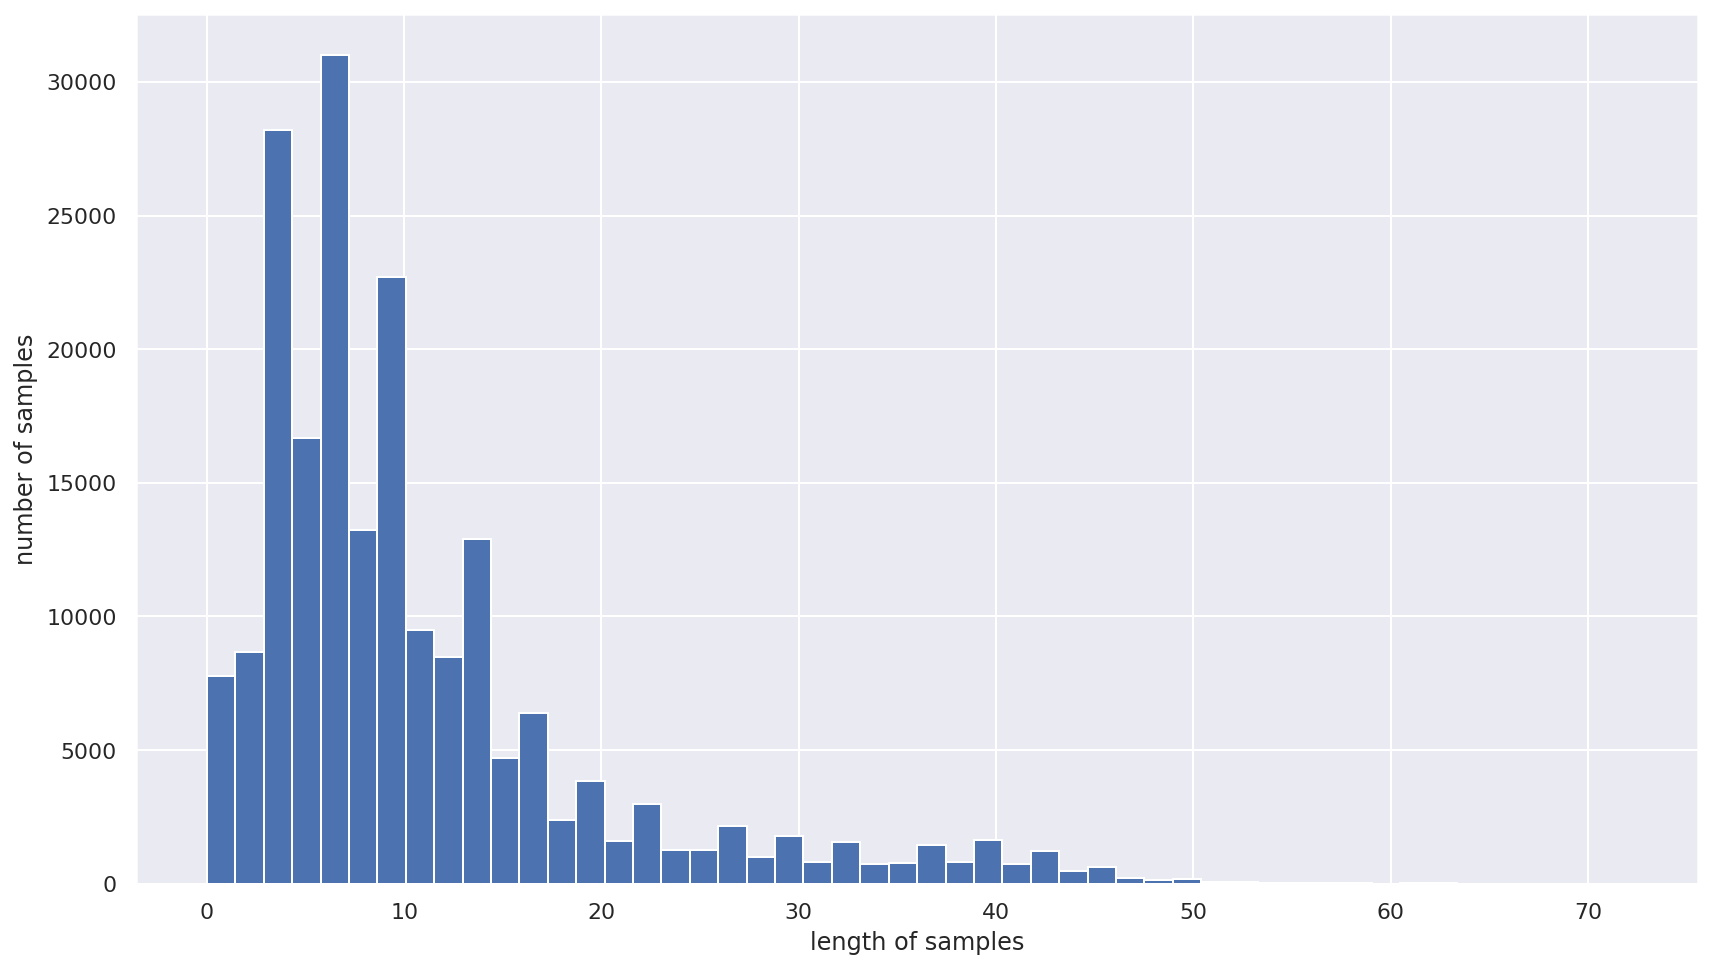

time: 673 ms (started: 2021-01-31 08:44:59 +00:00)


In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

time: 22.9 s (started: 2021-01-31 08:45:00 +00:00)


In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

time: 3.67 ms (started: 2021-01-31 08:45:23 +00:00)


In [ ]:
print(model.wv.most_similar("송강호"))

[('설경구', 0.9085257649421692), ('차승원', 0.8992759585380554), ('김혜수', 0.8848623633384705), ('류승범', 0.8793748021125793), ('한석규', 0.874467134475708), ('박중훈', 0.8705448508262634), ('정재영', 0.8689767122268677), ('안성기', 0.8669489622116089), ('최민수', 0.8625281453132629), ('디카프리오', 0.8615674376487732)]
time: 36 ms (started: 2021-01-31 08:45:23 +00:00)


## Digression: 유사도 계산

- 빈도 기반의 BOW, TF-IDF는 문장을 단어의 빈도로 표시해서 N차원의 벡터로 표시함. 
- word2vec 같은 단어 임베딩은 밀집행렬을 이용해서 표시함. 
- 어쨌든 위 두 가지 모두 기본적인 개념은 문서/문장/단어들을 숫자로 표시해서 N차원 공간의 벡터로 표시하는 것임. 
- 벡터들 사이 유사도는 두 벡터 사이의 '거리' 또는 '방향' 등으로 계산할 수 있음. 


**유클리디안 거리(Euclidean Distance)**

- 두 벡터 A, B 사이의 거리는 다음과 같이 측정할 수 있음:

\begin{equation}
distance(A,B) = \sqrt{(a_{1}-b_{1})^{2}+\cdots+(a_{n}-b_{n})^{2}}
\end{equation}

In [ ]:
# 아래에서 2차원인 경우 그림 확인
from IPython.display import IFrame
IFrame('https://en.wikipedia.org/wiki/Euclidean_distance', width=800, height=350)

time: 3.17 ms (started: 2021-01-31 12:08:55 +00:00)


**코사인 유사도(Cosine Similarity)**

- 코사인 유사도는 거리는 보지 않고, 두 벡터의 방향만 측정함.
- 같은 방향이면 1, 정반대 방향이면 -1, 서로 독립적이라면 0이 나옴. 

\begin{equation}
similarity(A,B) = cos(\theta)=\frac{A \cdot B}{\parallel A \parallel \parallel B \parallel} = \frac{\Sigma_{i=1}^{n}a_{i}b_{i}}{\sqrt{\Sigma_{i=1}^{n}a_{i}^{2}}\sqrt{\Sigma_{i=1}^{n}b_{i}^{2}}}
\end{equation}

- 코사인 유사도가 널리 쓰이나 분석 목적에 맞게 선택할 필요가 있음. 